# PS bunch generation: Pre-LIU parameters

In [44]:
# General imports
%matplotlib notebook
import sys
import numpy as np
from scipy.io import savemat
from scipy.constants import c
import matplotlib.pyplot as plt

# BLonD imports
sys.path.append('./BLonD')
from blond.beam.beam import Proton, Beam
from blond.input_parameters.ring import Ring
from blond.input_parameters.rf_parameters import RFStation
from blond.trackers.tracker import RingAndRFTracker, FullRingAndRF
from blond.beam.distributions import matched_from_line_density

In [45]:
def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [102]:
# Case selection
n_macroparticles = 5e5
#beam_selection = 'BCMS'
beam_selection = 'Nominal'

# PS ring parameters
circumference = 2*np.pi*100.
bending_radius = 70.07887
kinetic_energy = 1.4e9
gamma_t = 6.1

# 2 Intensities
high_intensity = True
i = 4

if high_intensity:
    bunch_intensity = 2.0E12
    str_intensity = '2E12'
else:
    bunch_intensity = 1.6E12   
    str_intensity = '1p6E12'

# PS bunch parameters Nominal
particle_type = Proton()
full_bunch_length = 210e-9
rf_harmonic = 7
# full_emittance = 1.2
line_density_type='parabolic_line'

emittances = [1.3, 1.6, 1.9, 2.3, 2.6]
str_emittances = ['1p3', '1p6', '1p9', '2p3','2p6']
voltages = [12.25E3, 18.9E3, 30.4E3, 45.5E3, 59.1E3]#original
#voltages = [12.3E3, 18.9E3, 30.4E3, 45.5E3, 59.1E3]


rf_voltage = voltages[i]

beam_label = str_intensity + '_' +str_emittances[i] + '_eVs'

#elif beam_selection == 'BCMS':
# PS rf parameters BCMS
#rf_harmonic = 9
#rf_voltage = 21.2e3
# PS bunch parameters BCMS
#particle_type = Proton()
#full_bunch_length = 150e-9
# full_emittance = 0.84
#bunch_intensity = 16.25e11
#line_density_type='parabolic_line'

In [103]:
# Constructing BLonD objects

# Ring object
ring = Ring(circumference, 1/gamma_t**2.,
            kinetic_energy, particle_type,
            synchronous_data_type='kinetic energy')

# RF object
rf_station = RFStation(ring, rf_harmonic,
                       rf_voltage, np.pi)

# Beam object
beam = Beam(ring, n_macroparticles, bunch_intensity)

# Tracker objects
total_induced = None

longitudinal_tracker = RingAndRFTracker(rf_station, beam,
                                        TotalInducedVoltage=total_induced)

full_tracker = FullRingAndRF([longitudinal_tracker])

# Bunch generation
output_profile = matched_from_line_density(
    beam, full_tracker,
    TotalInducedVoltage=total_induced,
    bunch_length=full_bunch_length,
    line_density_type=line_density_type)[1]



In [104]:
# Using blond_common to verify separatrix and emittance

from blond_common.rf_functions.potential import (
    rf_potential_generation, find_potential_wells_cubic,
    potential_well_cut_cubic, trajectory_area_cubic)

n_points = 1000
t_rev = ring.t_rev[0]
eta_0 = ring.eta_0[0,0]
tot_energy = ring.energy[0,0]
beta_rel = ring.beta[0,0]
charge = ring.Particle.charge
energy_increment = ring.delta_E[0]
voltage = rf_station.voltage[0,0]
harmonic = rf_station.harmonic[0,0]
phi_rf = rf_station.phi_rf[0,0]


# Separatrix trajectory
time_bounds_sep = [output_profile[0][0],
                   output_profile[0][-1]]

time_array, rf_potential_array = rf_potential_generation(
    n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment,
    time_bounds=time_bounds_sep)

potwell_max_locs = find_potential_wells_cubic(
    time_array, rf_potential_array)[0]

time_array_list, potential_well_list = potential_well_cut_cubic(
    time_array, rf_potential_array, potwell_max_locs)

(time_sep, dEsep, hamiltonian, calc_area_sep,
 half_energy_height, full_length_time) = trajectory_area_cubic(
    time_array_list[0], potential_well_list[0],
    eta_0, beta_rel, tot_energy)


# Outter bunch trajectory
time_bounds_bunch = [np.min(output_profile[0][output_profile[1]!=0.]),
                     np.max(output_profile[0][output_profile[1]!=0.])]

time_array, rf_potential_array = rf_potential_generation(
    n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment,
    time_bounds=time_bounds_bunch)

potwell_max_locs = find_potential_wells_cubic(
    time_array, rf_potential_array)[0]

(time_bunch, dEbunch, hamiltonian, calc_area_bunch,
 half_energy_height, full_length_time) = trajectory_area_cubic(
    time_array, rf_potential_array,
    eta_0, beta_rel, tot_energy)



<IPython.core.display.Javascript object>


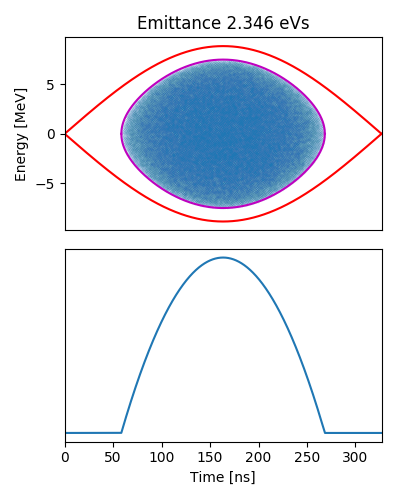

In [105]:
# Output figure

plt.figure('Beam', figsize=(4,5))
plt.clf()

plt.subplot(211)
plt.plot(beam.dt*1e9, beam.dE/1e6, '.',
         markersize=0.1, alpha=0.2)
plt.plot(time_bunch*1e9, dEbunch/1e6, 'm')
plt.plot(time_bunch*1e9, -dEbunch/1e6, 'm')
plt.plot(time_sep*1e9, dEsep/1e6, 'r')
plt.plot(time_sep*1e9, -dEsep/1e6, 'r')
plt.xlim((0, rf_station.t_rf[0,0]*1e9))
plt.gca().get_xaxis().set_visible(False)
plt.ylabel('Energy [MeV]')
plt.title('Emittance %.3f eVs'%(calc_area_bunch))

plt.subplot(212)
plt.plot(output_profile[0]*1e9, output_profile[1])
plt.xlim((0, rf_station.t_rf[0,0]*1e9))
plt.gca().get_yaxis().set_visible(False)
plt.xlabel('Time [ns]')

plt.tight_layout()
plt.savefig('figure_'+str(beam_label)+'.png')



# Turn into Tomo data file

<IPython.core.display.Javascript object>


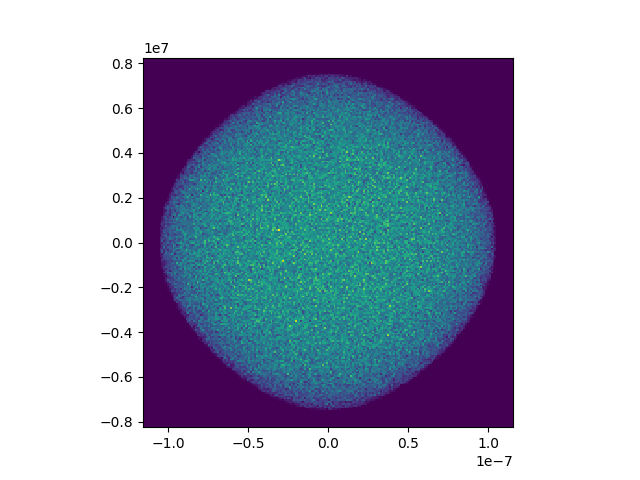

In [106]:
# First we need to make the data into a 2D array

# Start with our data
dE = np.array(beam.dE)
dt = np.array((beam.dt - rf_station.t_rf[0,0]/2.))

bin_size_x = 200
bin_size_y = 200
x_min = np.min(dt)*1.1
x_max = np.max(dt)*1.1
y_min = np.min(dE)*1.1
y_max = np.max(dE)*1.1

# Need a heatmap to make a 2D array:
# Create heatmap
fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

heatmap, xedges, yedges = np.histogram2d(dt, dE, bins=(bin_size_x, bin_size_y), range=[[x_min, x_max],[y_min, y_max]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax1.imshow(heatmap, extent=extent, aspect=( (x_min - x_max)/(y_min - y_max) ) )

In [107]:
# We want this in units of MeV and ns
data_dict = {'time_nsec': xedges*1E9, 'energy_MeV': yedges*1E-6, 'density_array': heatmap}
fname = str('PyORBIT_Tomo_file_' + beam_label + '.mat')
savemat(fname, data_dict)

## Tomo .mat file created

<IPython.core.display.Javascript object>


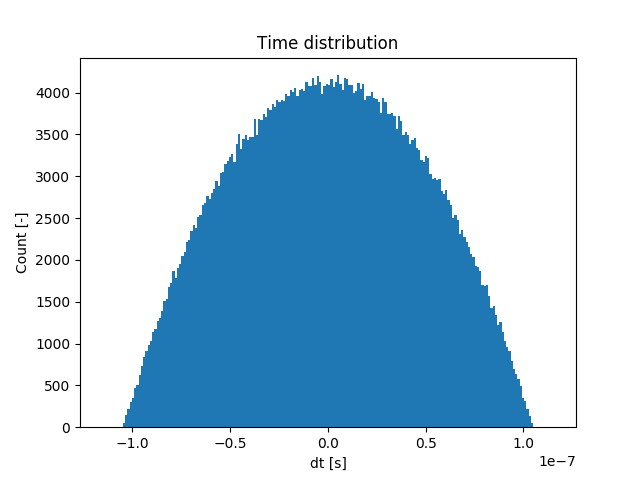

[Text(0, 0.5, 'Count [-]'),
 Text(0.5, 0, 'dt [s]'),
 Text(0.5, 1.0, 'Time distribution')]

In [96]:
# Check parabolic structure is maintained
# Create heatmap
fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

hist, bin_edges = np.histogram(dt, bins = bin_size_x, range=[x_min, x_max])
plt.hist(dt, bins = bin_size_x, range=[x_min, x_max])

ax1.set(xlabel='dt [s]', ylabel='Count [-]', title='Time distribution')

<IPython.core.display.Javascript object>


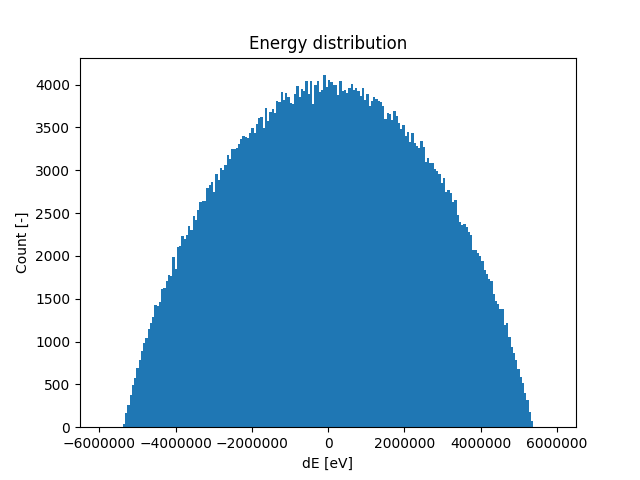

[Text(0, 0.5, 'Count [-]'),
 Text(0.5, 0, 'dE [eV]'),
 Text(0.5, 1.0, 'Energy distribution')]

In [42]:
# Check parabolic structure is maintained
# Create heatmap
fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

hist, bin_edges = np.histogram(dE, bins = bin_size_y, range=[y_min, y_max])
plt.hist(dE, bins = bin_size_y, range=[y_min, y_max])

ax1.set(xlabel='dE [eV]', ylabel='Count [-]', title='Energy distribution')

# Write tomo-style PyORBIT input file

In [35]:
# Save file for PyORBIT - Format 1 (untested)
text_file=0
if text_file:    

    fname = str('PyORBIT_Tomo_file_' + beam_label + '.txt')

    thefile = open(fname,"w")

    # First line: Minimum dt, maximum dt, binsize, bins (nanoseconds)
    thefile.write("%f\t%f\t%f\t%i" % (xedges[0]*1E9, xedges[-1]*1E9, np.abs(xedges[1]-xedges[0])*1E9, len(xedges)))

    # Second line: Minimum dE, maximum dE, binsize, bins (MeV)
    thefile.write("\n%f\t%f\t%f\t%i" % (yedges[0]*1E-6, yedges[-1]*1E-6, np.abs(yedges[1]-yedges[0])*1E-6, len(yedges)))

    # Write density as grid
    thefile.write("\n")
    data = heatmap

    for x in np.arange(len(xedges)-1):
        for y in np.arange(len(yedges)-1):
            thefile.write("%1.10f\t" % (heatmap[x, y]))
        thefile.write("\n")
    thefile.close()

In [100]:
# Saving distribution
save_dist = 0
if save_dist:
    particle_beta = np.sqrt(1-(beam.Particle.mass/(beam.energy+beam.dE))**2.)

    particle_z = -(beam.dt - rf_station.t_rf[0,0]/2.)*particle_beta*c

    np.savez('distribution_'+str(beam_selection)+'.npz',
             dt=(beam.dt - rf_station.t_rf[0,0]/2.),
             dz=particle_z,
             dE=beam.dE)